<a href="https://colab.research.google.com/github/gemme/resnet18/blob/resnet/neumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Flatten,Conv2D,MaxPooling2D

from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')
#_URL='https://data.mendeley.com/datasets/rscbjbr9sj/2/files/f12eaf6d-6023-432f-acc9-80c9d7393433/ChestXRay2017.zip'
_URL='file:///content/drive/MyDrive/deep-learning/pneumonia.zip'
zip_dir = tf.keras.utils.get_file('pneumonia.zip', origin=_URL, extract=True,cache_dir='/content',archive_format='auto')
print(zip_dir)


Mounted at /content/drive
2463365435/2463365435 [==============================] - 21s 0us/step
/content/datasets/pneumonia.zip


In [7]:
import numpy as np 
import random
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import cv2
import tensorflow
import keras
from keras.metrics import Recall
from keras import Model, callbacks
from keras.layers import Input, Dense, add, Conv2D, MaxPool2D ,GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
import warnings
import os
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'


In [8]:
train_path = '/content/datasets/chest_xray/train'
valid_path = '/content/datasets/chest_xray/val'
test_path = '/content/datasets/chest_xray/test'

In [9]:
BATCH_SIZE = 50
EPOCHS = 20
IMAGE_SIZE = (200, 200)

train_dataset = image_dataset_from_directory(train_path,
                                             seed=42,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMAGE_SIZE)

valid_dataset = image_dataset_from_directory(valid_path,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMAGE_SIZE)

test_dataset = image_dataset_from_directory(test_path,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMAGE_SIZE)


rescale = Rescaling(scale=1.0 / 255)
train_dataset = train_dataset.map(lambda image, label: (rescale(image), label))
valid_dataset  = valid_dataset.map(lambda image, label: (rescale(image), label))
test_dataset  = test_dataset.map(lambda image, label: (rescale(image), label))

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [10]:
cnt_imgs = 16  # we take 8 images for each class
norm_path = train_path + '/NORMAL'
pneumonia_path = train_path + '/PNEUMONIA'
norm_imgs = os.listdir(norm_path)[:cnt_imgs]
pneumonia_imgs = os.listdir(pneumonia_path)[:cnt_imgs]

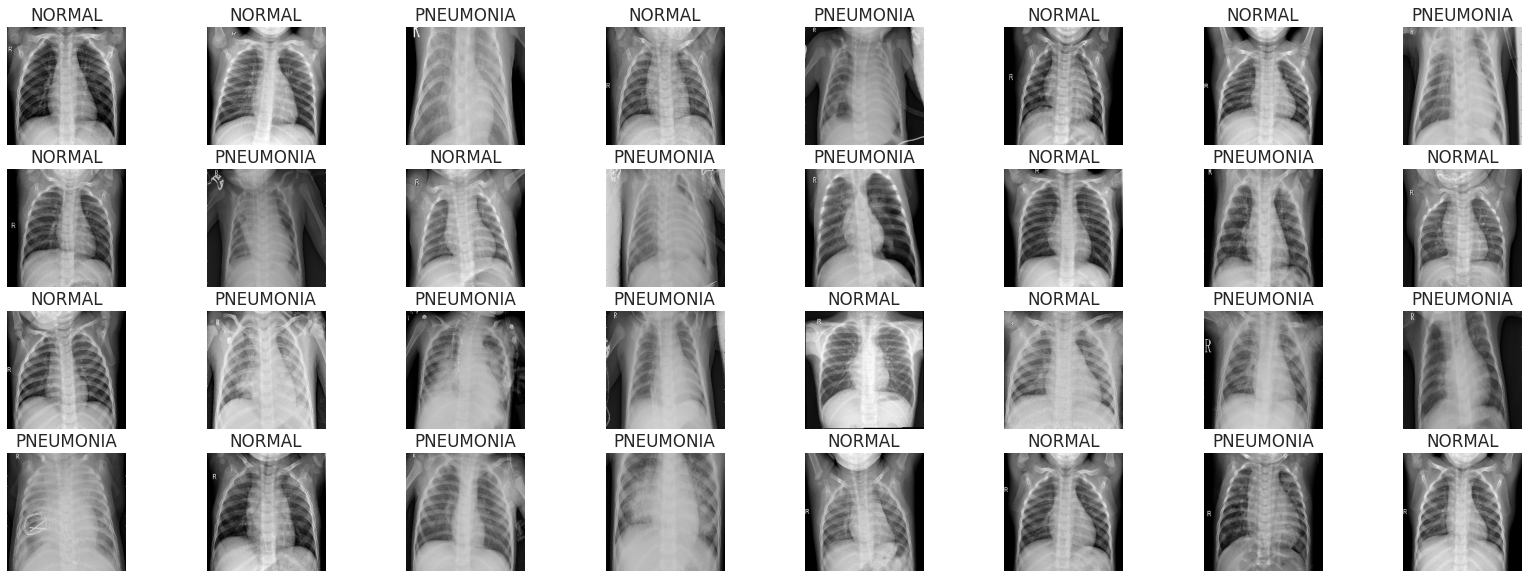

In [11]:
counter = 0
norm_imgs_path = [norm_path + '/' + i for i in norm_imgs]
pneumonia_imgs_path = [pneumonia_path + '/' + j for j in pneumonia_imgs]
all_imgs = norm_imgs_path + pneumonia_imgs_path
random.shuffle(all_imgs)

plt.figure(figsize=(28, 10))
for img_path in all_imgs:
    plt.subplot(4, 8, counter + 1)
    img = cv2.imread(img_path)
    img = cv2.resize(img, IMAGE_SIZE)
    label = img_path[len(train_path) + 1: img_path.rfind('/')]
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
    counter += 1

In [12]:
def check_cnt_label(label: str) -> int:
    """A function that should determine the number of objects of this
    class in the specified directories"""
    cnt_object = 0
    paths = [train_path, valid_path, test_path]
    for path in paths:
        path += '/' + label
        cnt_object += len(os.listdir(path))
    return cnt_object

CNT_NORMAL = check_cnt_label('NORMAL')
CNT_PNEUMONIA = check_cnt_label('PNEUMONIA')

In [13]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['NORMAL', 'PNEUMONIA'],
    y=[CNT_NORMAL, CNT_PNEUMONIA],
    name='Primary Product',
    marker_color='indianred',
    width=[0.4, 0.4]))

fig.update_layout(title='Classes and their number in the dataset', title_x=0.5)

In [15]:
inputs = Input(shape=(IMAGE_SIZE + (3,)))

x = Conv2D(32, (3, 3), activation='elu')(inputs)
x = Conv2D(64, (3, 3), activation='elu')(x)
block_1_output = MaxPool2D(pool_size=(3, 3))(x)

x = Conv2D(64, (3, 3), activation='elu', padding='same')(block_1_output)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='elu', padding='same')(x)
block_2_output = add([x, block_1_output])

x = Conv2D(64, (3, 3), activation='elu', padding='same')(block_2_output)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='elu', padding='same')(x)
block_3_output = add([x, block_2_output])

x = Conv2D(128, (3, 3), activation='elu')(block_3_output)
x = MaxPool2D(pool_size=(2, 2))(x)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='elu')(x)
x = Dropout(0.4)(x)
output = Dense(1, activation='sigmoid')(x)


In [16]:
model = Model(inputs, output)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 198, 198, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 196, 196, 64  18496       ['conv2d[0][0]']                 
                                )                                                             

In [17]:
model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=[Recall()])

In [18]:
CALLBACKS = [
    callbacks.EarlyStopping(monitor='loss', min_delta=0.01, patience=8, verbose=1),  
    callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, min_delta=0.01, min_lr=1e-10, patience=4, verbose=1, mode='auto')
]

In [19]:
history = model.fit(train_dataset, epochs=EPOCHS, validation_data=valid_dataset, callbacks=CALLBACKS)

Epoch 1/20
105/105 [==============================] - 46s 300ms/step - loss: 0.3073 - recall: 0.9086 - val_loss: 0.7909 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 2/20
105/105 [==============================] - 34s 304ms/step - loss: 0.2509 - recall: 0.9257 - val_loss: 4.9095 - val_recall: 1.0000 - lr: 0.0010
Epoch 3/20
105/105 [==============================] - 33s 289ms/step - loss: 0.2235 - recall: 0.9357 - val_loss: 0.9052 - val_recall: 1.0000 - lr: 0.0010
Epoch 4/20
105/105 [==============================] - 33s 293ms/step - loss: 0.2057 - recall: 0.9386 - val_loss: 5.3174 - val_recall: 1.0000 - lr: 0.0010
Epoch 5/20
105/105 [==============================] - 33s 293ms/step - loss: 0.1614 - recall: 0.9523 - val_loss: 4.8663 - val_recall: 1.0000 - lr: 0.0010
Epoch 6/20
105/105 [==============================] - 33s 294ms/step - loss: 0.1654 - recall: 0.9528 - val_loss: 1.2058 - val_recall: 0.1250 - lr: 0.0010
Epoch 7/20
105/105 [==============================] - 33s 293ms/step - l

In [20]:
test_result = model.evaluate(test_dataset)
train_result = model.evaluate(train_dataset)

105/105 [==============================] - 28s 243ms/step - loss: 1.4737 - recall: 0.4126


In [24]:
print(f'Metric (Recall) on test set: {test_result[1]}')
print(f'Metric (Recall) on train set: {train_result[1]}')

Metric (Recall) on test set: 0.5051282048225403
Metric (Recall) on train set: 0.412645161151886


In [32]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    print(history.history)
    plt.plot(history.history['recall'],'bo--', label = 'recall')
    plt.plot(history.history['val_recall'], 'ro--', label = 'val_recall')
    plt.title("train_accuracy vs val_recall")
    plt.ylabel("recall")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = 'loss')
    plt.plot(history.history['val_loss'], 'ro--', label = 'val_loss')
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

{'loss': [0.307258665561676, 0.2508813142776489, 0.2235058695077896, 0.20568986237049103, 0.16142307221889496, 0.165403351187706, 0.1718054711818695, 0.16516508162021637, 0.11868782341480255, 0.10907901078462601, 0.12081856280565262, 0.10292098671197891, 0.09143424779176712, 0.10440637916326523, 0.08459284901618958, 0.07545202225446701, 0.08545996993780136, 0.07683894038200378, 0.06544369459152222, 0.06627503782510757], 'recall': [0.9086451530456543, 0.9256774187088013, 0.9357419610023499, 0.9385806322097778, 0.9522580504417419, 0.952774167060852, 0.9530322551727295, 0.953806459903717, 0.9705806374549866, 0.9731612801551819, 0.9713548421859741, 0.9741935729980469, 0.9778064489364624, 0.9749677181243896, 0.9796128869056702, 0.9816774129867554, 0.9788386821746826, 0.9796128869056702, 0.9837419390678406, 0.984000027179718], 'val_loss': [0.7908535003662109, 4.909548282623291, 0.9052148461341858, 5.3174147605896, 4.866252422332764, 1.2058138847351074, 3.3645360469818115, 2.9787402153015137,

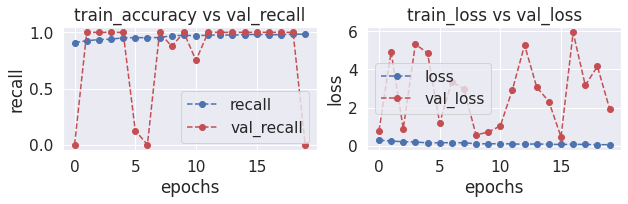

In [33]:
plot_accuracy_loss(history)